In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score,cross_validate, RandomizedSearchCV, train_test_split
import optuna
import xgboost as xgb
from sklearn.metrics import r2_score 
import joblib

In [2]:
df2 = pd.read_excel("../markaFile/Citroen.xlsx",sheet_name="Sheet1")

In [3]:
df2.drop("Unnamed: 0",axis=1, inplace=True)

In [4]:
df2.drop(df2[(df2["Fiyat"] > 1000000)].index, axis=0, inplace=True)

In [5]:
df2.head()

,Fiyat,Yıl,Motor Gücü,Motor Hacmi,Kilometre,Boya,Değişen,Seri_AX,Seri_C-Elysee,Seri_C1,...,Model_Picasso 1.6 HDi Exclusive,Model_Picasso 1.6 SX,Model_Picasso 1.8 Exclusive,Model_Picasso 2.0 HDi,Yakıt Tipi_Benzin,Yakıt Tipi_Dizel,Yakıt Tipi_LPG & Benzin,Vites Tipi_Düz,Vites Tipi_Otomatik,Vites Tipi_Yarı Otomatik
0,436500,0.545455,-0.250000,0.000000,-0.374532,NaN,NaN,0,1,0,...,0,0,0,0,0,1,0,1,0,0
1,240000,0.000000,-0.861111,-0.778846,0.524345,NaN,NaN,0,0,0,...,0,0,0,0,0,1,0,1,0,0
2,275000,0.000000,-0.861111,-0.778846,-0.022472,NaN,NaN,0,0,0,...,0,0,0,0,0,1,0,1,0,0
3,218000,-0.363636,-0.861111,-0.778846,0.808989,NaN,NaN,0,0,0,...,0,0,0,0,0,1,0,1,0,0
4,516990,0.090909,0.333333,0.000000,0.322097,NaN,NaN,0,0,0,...,0,0,0,0,0,1,0,0,0,1


In [6]:
y = df2["Fiyat"]
X = df2.drop(["Fiyat"], axis=1)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [8]:
def set_model(model_list, X_train, X_test, y_train, y_test):
    dataf = pd.DataFrame()

    for i in range(len(model_list)):
        algo_name = model_list[i][0]
        algo = model_list[i][1]

        model = algo.fit(X_train, y_train)

        cv_result = cross_val_score(model,
                                    X_train, y_train,
                                    cv=5,
                                    scoring="neg_mean_squared_error")

        y_pred = model.predict(X_test)
        rmse = np.mean(np.sqrt(-cv_result))
        data_list = {"Model": algo_name,
                     "TestDeger": rmse,
                     "MSE":mean_squared_error(y_test, y_pred),
                     "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
                     "MAE": mean_absolute_error(y_test, y_pred)}
        dataf = dataf.append(data_list, ignore_index=True)

    return dataf

In [9]:
models = []
#models.append(('Gradient Boosting Regressor', GradientBoostingRegressor()))
models.append(('XGBModel', XGBRegressor(objective="reg:squarederror",use_label_encoder=False)))
#models.append(('LGBMModel', LGBMRegressor(use_missing=False)))
#models.append(('LRModel', LinearRegression()))
#models.append(('RFModel', RandomForestRegressor()))

In [10]:
df2_model = set_model(models, X_train, X_test, y_train, y_test)
df2_model

C:\Users\senab\AppData\Local\Temp\ipykernel_15576\3059390516.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataf = dataf.append(data_list, ignore_index=True)


,Model,TestDeger,MSE,RMSE,MAE
0,XGBModel,45667.095357,1.457209e+09,38173.40517,27991.516291


In [11]:
def objective(n_trials):
  params = {
        'colsample_bytree': n_trials.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': n_trials.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        "learning_rate": n_trials.suggest_float("learning_rate", 1e-4, 0.5, log=True),
        'n_estimators': 10000,
        "max_depth": n_trials.suggest_int("max_depth", 3, 15),
        'min_child_weight': n_trials.suggest_int('min_child_weight', 1, 300),
    }
  dtrain = xgb.DMatrix(data = X_train, label = y_train)
  dval = xgb.DMatrix(data = X_test, label = y_test)

  regressor = xgb.train(params, dtrain) 
  y_pred = regressor.predict(dval)
  rmse = mean_squared_error(y_test, y_pred, squared=False)

  return rmse

In [12]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=250, n_jobs=-1)

[I 2023-05-23 20:46:54,768] A new study created in memory with name: no-name-a5636334-9ec7-4d1b-a5ae-085ea7effe38
[I 2023-05-23 20:46:54,946] Trial 0 finished with value: 398272.60556997766 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.0006898041688952608, 'max_depth': 10, 'min_child_weight': 237}. Best is trial 0 with value: 398272.60556997766.
[I 2023-05-23 20:46:54,954] Trial 1 finished with value: 399840.64777572657 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.00027955975560087264, 'max_depth': 6, 'min_child_weight': 261}. Best is trial 0 with value: 398272.60556997766.
[I 2023-05-23 20:46:54,975] Trial 2 finished with value: 195849.04317498818 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.07364206166132295, 'max_depth': 12, 'min_child_weight': 124}. Best is trial 2 with value: 195849.04317498818.
[I 2023-05-23 20:46:54,982] Trial 3 finished with value: 144143.14981832757 and paramet

[I 2023-05-23 20:46:56,444] Trial 32 finished with value: 83393.01256324 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.5, 'learning_rate': 0.16477432144452933, 'max_depth': 15, 'min_child_weight': 12}. Best is trial 28 with value: 41378.599446996814.
[I 2023-05-23 20:46:56,525] Trial 34 finished with value: 88084.04468506498 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.5, 'learning_rate': 0.15924778466314193, 'max_depth': 10, 'min_child_weight': 1}. Best is trial 28 with value: 41378.599446996814.
[I 2023-05-23 20:46:56,539] Trial 31 finished with value: 110941.81488880957 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.5, 'learning_rate': 0.13258285239865517, 'max_depth': 15, 'min_child_weight': 2}. Best is trial 28 with value: 41378.599446996814.
[I 2023-05-23 20:46:56,578] Trial 33 finished with value: 103059.86600473929 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.5, 'learning_rate': 0.14069020240674876, 'max_depth': 15, 'min_child_weight

[I 2023-05-23 20:46:58,347] Trial 59 finished with value: 60606.02972937369 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.2122385766654095, 'max_depth': 5, 'min_child_weight': 89}. Best is trial 30 with value: 40895.1084276521.
[I 2023-05-23 20:46:58,481] Trial 60 finished with value: 46855.803742991535 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.3324303619612471, 'max_depth': 4, 'min_child_weight': 89}. Best is trial 30 with value: 40895.1084276521.
[I 2023-05-23 20:46:58,512] Trial 61 finished with value: 44565.49608749349 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.33082811458139444, 'max_depth': 4, 'min_child_weight': 44}. Best is trial 30 with value: 40895.1084276521.
[I 2023-05-23 20:46:58,571] Trial 62 finished with value: 42726.540682652194 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.388441699123211, 'max_depth': 4, 'min_child_weight': 44}. B

[I 2023-05-23 20:47:00,588] Trial 89 finished with value: 46382.317701265856 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.41003993262825905, 'max_depth': 4, 'min_child_weight': 39}. Best is trial 63 with value: 40784.666594061375.
[I 2023-05-23 20:47:00,670] Trial 90 finished with value: 43464.20646737807 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.41902916306000226, 'max_depth': 4, 'min_child_weight': 44}. Best is trial 63 with value: 40784.666594061375.
[I 2023-05-23 20:47:00,912] Trial 91 finished with value: 42039.8655596474 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.4288660077096257, 'max_depth': 15, 'min_child_weight': 27}. Best is trial 63 with value: 40784.666594061375.
[I 2023-05-23 20:47:00,930] Trial 93 finished with value: 42250.45467176772 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.40075432689751056, 'max_depth': 15, 'min_child_weight

[I 2023-05-23 20:47:02,591] Trial 117 finished with value: 41434.786865611866 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.4974385109708205, 'max_depth': 11, 'min_child_weight': 34}. Best is trial 113 with value: 39667.14566258788.
[I 2023-05-23 20:47:02,643] Trial 120 finished with value: 41951.994173481966 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.5, 'learning_rate': 0.45125257799853435, 'max_depth': 11, 'min_child_weight': 33}. Best is trial 113 with value: 39667.14566258788.
[I 2023-05-23 20:47:02,648] Trial 122 finished with value: 41754.204612465706 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.4966912922191099, 'max_depth': 10, 'min_child_weight': 35}. Best is trial 113 with value: 39667.14566258788.
[I 2023-05-23 20:47:02,665] Trial 121 finished with value: 41749.843665067165 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.5, 'learning_rate': 0.48944604920433216, 'max_depth': 11, 'min_chi

[I 2023-05-23 20:47:04,819] Trial 149 finished with value: 39463.84578487095 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.35601724836876464, 'max_depth': 14, 'min_child_weight': 10}. Best is trial 149 with value: 39463.84578487095.
[I 2023-05-23 20:47:04,820] Trial 151 finished with value: 40050.979002910855 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.35386807111608365, 'max_depth': 14, 'min_child_weight': 9}. Best is trial 149 with value: 39463.84578487095.
[I 2023-05-23 20:47:04,821] Trial 150 finished with value: 39927.04365904368 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.35421397877823607, 'max_depth': 14, 'min_child_weight': 12}. Best is trial 149 with value: 39463.84578487095.
[I 2023-05-23 20:47:05,119] Trial 152 finished with value: 39907.765961947596 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.35881623858537726, 'max_depth': 13, 'min_chil

[I 2023-05-23 20:47:06,914] Trial 179 finished with value: 38102.67241636062 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.36866179277840766, 'max_depth': 13, 'min_child_weight': 1}. Best is trial 176 with value: 37961.57756339031.
[I 2023-05-23 20:47:06,935] Trial 181 finished with value: 39136.05706276932 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.3356943739484243, 'max_depth': 13, 'min_child_weight': 2}. Best is trial 176 with value: 37961.57756339031.
[I 2023-05-23 20:47:06,971] Trial 180 finished with value: 40272.58940734879 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.33222781944985547, 'max_depth': 13, 'min_child_weight': 2}. Best is trial 176 with value: 37961.57756339031.
[I 2023-05-23 20:47:07,001] Trial 183 finished with value: 38878.42414941844 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.39361637478327344, 'max_depth': 13, 'min_child_wei

[I 2023-05-23 20:47:09,195] Trial 209 finished with value: 41888.00373174485 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.2840830247970277, 'max_depth': 14, 'min_child_weight': 8}. Best is trial 176 with value: 37961.57756339031.
[I 2023-05-23 20:47:09,239] Trial 210 finished with value: 41214.93534097742 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.49150225960273297, 'max_depth': 14, 'min_child_weight': 11}. Best is trial 176 with value: 37961.57756339031.
[I 2023-05-23 20:47:09,489] Trial 212 finished with value: 379733.4389382317 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.005563095973374707, 'max_depth': 12, 'min_child_weight': 1}. Best is trial 176 with value: 37961.57756339031.
[I 2023-05-23 20:47:09,495] Trial 213 finished with value: 41681.064755458625 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.4989558266515662, 'max_depth': 12, 'min_child_w

[I 2023-05-23 20:47:11,618] Trial 239 finished with value: 48060.670103859455 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.2571429171481113, 'max_depth': 14, 'min_child_weight': 1}. Best is trial 176 with value: 37961.57756339031.
[I 2023-05-23 20:47:11,677] Trial 240 finished with value: 45744.469654573644 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.26849439232236305, 'max_depth': 14, 'min_child_weight': 9}. Best is trial 176 with value: 37961.57756339031.
[I 2023-05-23 20:47:11,773] Trial 241 finished with value: 398153.94084805547 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.0007093392490880958, 'max_depth': 15, 'min_child_weight': 9}. Best is trial 176 with value: 37961.57756339031.
[I 2023-05-23 20:47:11,775] Trial 242 finished with value: 45621.190477860066 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.2696257933319945, 'max_depth': 15, 'min_chil

In [13]:
print(f"Optimized RMSE: {study.best_value:.4f}")
print("Best params:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")

Optimized RMSE: 37961.5776
Best params:
	colsample_bytree: 0.5
	subsample: 0.8
	learning_rate: 0.3806611486961324
	max_depth: 13
	min_child_weight: 2


In [14]:
model = XGBRegressor(objective="reg:squarederror",use_label_encoder=False)
grid_params = {"learning_rate": [0.1, 0.36],
                  "max_depth": [9,13],
                  "n_estimators": [500,750,1000],
               'colsample_bytree': [0.5],
               'subsample': [0.8],
               'min_child_weight': [2]
              }

grid_model = GridSearchCV(estimator=model,
                                  param_grid=grid_params,
                                  cv=3,
                                  verbose=True,
                                  n_jobs=1).fit(X_train,y_train)


grid_final_model = model.set_params(**grid_model.best_params_).fit(X_train,y_train)
    
cv_results = cross_validate(grid_final_model,
                            X_train, y_train,
                            cv=5,
                            scoring="neg_mean_squared_error")
print("BEST PARAMS: ", grid_model.best_params_)
    
y_pred = grid_final_model.predict(X_test)

rmse = (np.sqrt(-cv_results['test_score'])).mean()
data_list = {"TestDeger": rmse,
             "MSE":mean_squared_error(y_test, y_pred),
             "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
             "MAE": mean_absolute_error(y_test, y_pred)}

print(data_list)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
BEST PARAMS:  {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 2, 'n_estimators': 500, 'subsample': 0.8}
{'TestDeger': 44296.165457400915, 'MSE': 1511165202.0517964, 'RMSE': 38873.70836506078, 'MAE': 28885.865488406183}


In [15]:
r2 = r2_score(y_test, y_pred)
r2

0.907283949201497

In [16]:
n= len(X_train)
p =len(X.columns)
adj_R2 = 1- ((1-r2) * (n-1)/(n-p-1))
adj_R2

0.8938862371489384

In [18]:
marka_model = joblib.dump(grid_final_model, "Citroen.pkl")

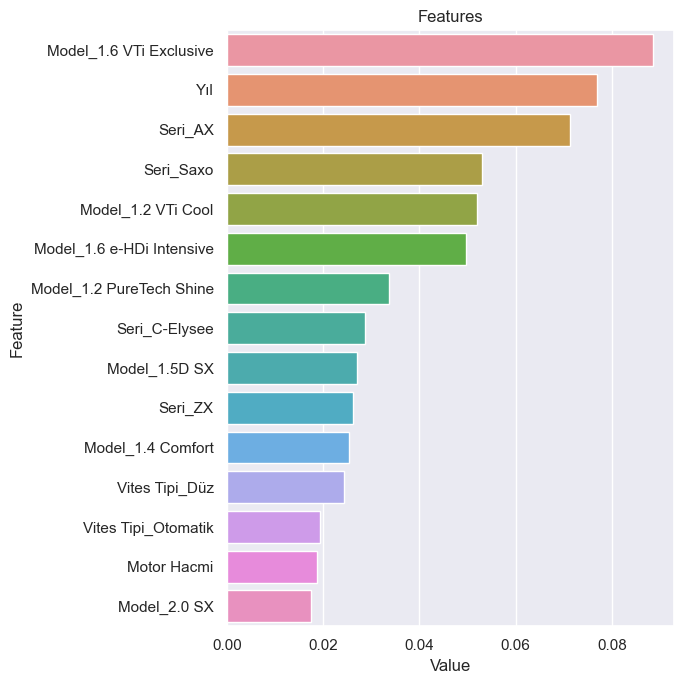

In [17]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(7, 7))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:15])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")
plot_importance(grid_final_model,X)

In [18]:
y_test2 = list(y_test)

In [19]:
df3 = pd.DataFrame(list(zip(y_test, y_pred,(y_pred-y_test))),
               columns =['test', 'pred',"fark"])

In [20]:
df3

,test,pred,fark
0,168500,123125.140625,-45374.859375
1,345000,354978.562500,9978.562500
2,205000,286982.625000,81982.625000
3,455000,429754.343750,-25245.656250
4,285000,290841.250000,5841.250000
...,...,...,...
466,630000,545333.062500,-84666.937500
467,464750,480737.500000,15987.500000
468,396000,379722.125000,-16277.875000
469,475000,474895.468750,-104.531250


In [21]:
df3.describe([0.05,0.25, 0.75,0.90,0.99]).T

,count,mean,std,min,5%,25%,50%,75%,90%,99%,max
test,471.0,399862.191083,229039.974623,9.050000e+04,177500.000000,290000.000000,390000.000,465000.000000,559500.00000,754500.00000,4.350000e+06
pred,471.0,386051.937500,130966.945312,1.014875e+05,175274.164062,293813.562500,381125.250,463002.890625,542972.93750,760347.36875,9.096226e+05
fark,471.0,-13810.275743,189582.255273,-3.900788e+06,-77647.359375,-26970.515625,-308.375,21781.187500,42974.09375,98623.87500,2.873716e+05


In [22]:
df3["test"].max()

4350000

In [23]:
df3[df3["test"]==4350000]

,test,pred,fark
428,4350000,449211.78125,-3.900788e+06


In [25]:
df3[df3["test"] > 1000000]

,test,pred,fark
173,1100003,190055.484375,-9.099475e+05
273,1150000,909622.562500,-2.403774e+05
428,4350000,449211.781250,-3.900788e+06


In [33]:
y_train2 = list(y_train)

In [39]:
for i in y_train2:
    if i > 1000000:
        print(i)

1105000
